#### Task 1 -  To Find the largest number<br></br>You have two integers, either positive or negative, and the challenge is to generate a quantum algorithm that returns which is the larger number. <br></br>Consider an appropriate number of qubits and explain why your proposal is valid for all kinds of numbers in case.

### Importing all the necessary libraries required

In [1]:
import numpy as np
from qiskit import QuantumCircuit,Aer,execute
import math

#### Our first task is to create a quantum bit string comparator, which involves breaking down the problem into two subproblems. 

#### The first subproblem is to encode the two numbers using the least number of qubits possible through a quantum circuit. The second subproblem is to create another quantum circuit that will check the comparison.

#### After studying the research paper at https://ieeexplore.ieee.org/document/4433341 & especially https://arxiv.org/pdf/2005.08950.pdf, I was inspired to adopt their approach. However, I eventually came up with a novel concept that I believed was unique to my work.

#### Creating Utility Functions

In [2]:
def binary(a:int,b:int):
    """
    Description -> The given code defines a function named "binary" which takes two integer arguments, "a" and "b".
                   The purpose of the function is to convert the given integers into binary form by creating a 
                   string representation of their binary bits. The function uses a while loop to iterate over the
                   binary bits of the given integers. 
                   
                   It starts by initializing two empty strings, "x" and "y", to which the binary bits 
                   are appended in reverse order using the modulo operator and integer division. 
                   
                   The resulting strings are then reversed to obtain the correct binary representation.
                   After obtaining the binary representation of the integers, the function compares the length 
                   of the two binary strings and pads the shorter string with leading zeros to make them equal 
                   in length. Finally, the function returns the two equal-length binary strings as output.
    """
    x=str()
    while(a!=0):
        x+=str(a%2)
        a=int(a/2) 
    x=x[::-1]
    y=str()
    while(b!=0):
        y+=str(b%2)
        b=int(b/2) 
    y=y[::-1]    
    if(len(x)<len(y)):
        x=x.zfill(len(y))
    elif(len(x)>len(y)):            
        y=y.zfill(len(x))
    return x,y

In [3]:
binary(5,17)

('00101', '10001')

In [4]:
def createqc(x): 
    """
    Description ->  The given code defines a function named "createqc" which takes an integer argument "x". 
                    The purpose of this function is to create a quantum circuit that performs a probabilistic 
                    operation based on the input "x".

                    The function starts by creating a QuantumCircuit object with one qubit and one classical bit. 
                    It applies a Hadamard gate on the qubit to create a superposition of states, i.e., a uniform 
                    probability distribution of the qubit being in either state 0 or 1.

                    The function then checks the input "x" to determine the probability distriution of the qubit 
                    collapsing to either state 0 or 1. If "x" is 0, the qubit has a 70% chance of collapsing to 
                    state 0 and a 30% chance of collapsing to state 1. To achieve this, the function applies a 
                    rotation around the y-axis by an angle of negative pi/8 radians (or -22.5 degrees) to the 
                    qubit using the RY gate. If "x" is not 0, the qubit has a 70% chance of collapsing to state 
                    1 and a 30% chance of collapsing to state 0. To achieve this, the function applies a rotation 
                    around the y-axis by an angle of pi/8 radians (or 22.5 degrees) to the qubit using the RY gate.
                    
                    Finally, the function returns the created quantum circuit as output.

    """
    qc = QuantumCircuit(1, 1)
    qc.h(0)
    if x==0:       
        ##75% 0 25% 1
        qc.ry(-math.pi/8, 0)    
    else:        
        ##25% 0 75% 1
        qc.ry(math.pi/8, 0)
    return qc

{'1': 287, '0': 737}


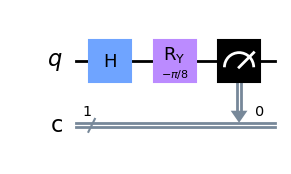

In [5]:
circuit=createqc(0)
circuit.measure(0, 0)
simulator = Aer.get_backend('qasm_simulator')
job = execute(circuit, simulator, shots=1024)
result = job.result()
print(result.get_counts(circuit))
circuit.draw('mpl')

{'0': 308, '1': 716}


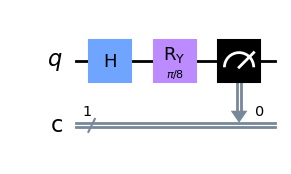

In [6]:
circuit=createqc(1)
circuit.measure(0, 0)
simulator = Aer.get_backend('qasm_simulator')
job = execute(circuit, simulator, shots=1024)
result = job.result()
print(result.get_counts(circuit))
circuit.draw('mpl')

In [7]:
#encoding both the numbers in n quantumcircuits with each quantumcircuit containing just one qubit

def encode(a:int,b:int):    
    """
    Description -> The given code defines a function named "encode" which takes two integer arguments "a" and "b".
                   The purpose of this function is to encode the two integers in binary form using a quantum
                   circuit. The function starts by calling the "binary" function with the given integers "a" 
                   and "b" to obtain their binary representation as strings. It then initializes an empty list 
                   "z" which will contain the quantum circuits used for encoding.

                   The function then iterates over the binary bits of the two numbers using a for loop. For 
                   each bit, it checks whether the corresponding bits in "a" and "b" are equal. If the bits 
                   are not equal, the function creates a quantum circuit using the "createqc" function with the 
                   value of the bit in "a" as input. This quantum circuit probabilistically encodes the qubit 
                   in the state 0 or 1 based on the value of the digit. The resulting quantum circuit is appended 
                   to the list "z". If the bits are equal, the function creates a quantum circuit that prepares
                   the qubit in the same state as the corresponding bit in "a" using the X gate if the digit is 
                   1, or doing nothing if the digit is 0.

                   Finally, the function returns the list "z" containing the quantum circuits used for encoding
    """
    a,b=binary(a,b)    
    z=list()
    for i in range(len(a)):
        if a[i]!=b[i]:                                    
            z.append(createqc(int(a[i])))
        else:
            qc=QuantumCircuit(1,1)
            if a[i]=='1':
                qc.x(0)                
            z.append(qc)
    return z

#### The main idea of leveraging the "quantumness" to our advantage is to utilize superposition for encoding 2n bits of data into n qubits.

1) more counts of '0' means that 'a' had the 0 as the bit and 'b' had the 1 at 'i'th index

2) a is set to get '0' or '1' whichever has more count

3) b is set to get '0' or '1' whichever has less count

In [8]:
def compare(a:int,b:int)->int:
    """
    Description -> The given code defines a function named "compare" which takes two integer arguments
                   "a" and "b" and returns an integer. The purpose of this function is to compare the two integers 
                   using a quantum circuit and return the larger of the two.

                   The function first checks if one of the numbers is positive and the other is negative. If this 
                   is the case, the function returns the positive number. This is because any positive number 
                   is greater than any negative number. If both numbers are negative, the function proceeds 
                   to encode them using the "encode" function. It then iterates over the quantum circuits 
                   in the resulting list and applies a measurement to the qubit in each circuit. It then 
                   uses the QASM simulator to execute the circuit with 1024 shots and obtains the measurement 
                   results. If the number of results where the qubit collapsed to state 0 is greater than the 
                   number of results where it collapsed to state 1 for a circuit, the function returns "a". 
                   Otherwise, it returns "b".

                   If both numbers are positive or zero, the function follows the same procedure as above to
                   encode the numbers and measure the qubits. However, in this case, it returns the larger of 
                   the two numbers instead of the smaller.

                   If the two numbers are equal, the function returns "a".
    """
    if a > 0 and b < 0:        
        return a
    if a < 0 and b > 0:        
        return b    
    l=encode(a,b)
    if a<0 and b<0:        
        for circuit in l:  
            if circuit.depth()!=2:
                continue
            circuit.measure(0, 0)
            simulator = Aer.get_backend('qasm_simulator')
            job = execute(circuit, simulator, shots=1024)
            result = job.result().get_counts(circuit)            
            if result['0']>result['1']:
                return a
            else:
                return b  
    else:
        for circuit in l:  
            if circuit.depth()!=2:
                continue
            circuit.measure(0, 0)
            simulator = Aer.get_backend('qasm_simulator')
            result = execute(circuit, simulator, shots=1024).result().get_counts(circuit)            
            if result['0']>result['1']:
                return b
            else:
                return a          
    return a##they equal

#### Testing the function

In [9]:
print("If both numbers are positive")
print(compare(10,200))

If both numbers are positive
200


In [10]:
print("If both numbers are negative")
print(compare(-10,-200))

If both numbers are negative
-10


In [11]:
print("If one number is positive and another is negative")
print(compare(-10,200))

If one number is positive and another is negative
200


In [12]:
print("If one number is positive and another is negative(order of inputs does not matter)")
print(compare(200,-10))

If one number is positive and another is negative(order of inputs does not matter)
200
